# Generate 2D Data

Notebook to generate 2D data for active learning paper

In [47]:
import numpy as np
import dask.array as da

from pymks import (
    generate_multiphase,
    plot_microstructures,
    solve_fe
)

## Generate Data Functions

Functions to generate the microstructure. The microstructures are stochastically generated from 6 nominal classes.

In [59]:
?generate_multiphase

In [49]:
def shuffle(data):
    tmp = np.array(data)
    np.random.shuffle(tmp)
    return da.from_array(tmp, chunks=data.chunks)

def generate_x(shape, seed):
    da.random.seed(seed)
    np.random.seed(seed)

    tmp = [
        generate_multiphase(shape=shape, grain_size=x, volume_fraction=(0.5, 0.5), chunks=100, percent_variance=0.15)
        for x in [(15, 2), (2, 15), (7, 7), (9, 3), (3, 9), (2, 2)]
    ]
    return np.array(shuffle(da.concatenate(tmp)))


#def shuffle(data, chunk_size):
#    tmp = np.array(data)
#    np.random.shuffle(tmp)
#    return da.from_array(tmp, chunks=(chunk_size,) + tmp.shape[1:])

#def generate_x(shape, n_sample, seed, max_size=20, chunk_size=100):
#    da.random.seed(seed)
#    np.random.seed(seed)#

#    tmp = [
#        generate_multiphase(shape=(1,) + shape, grain_size=x, volume_fraction=(0.5, 0.5), chunks=1, percent_variance=0.15)
#        for x in np.random.randint(2, 20, size=(n_sample, 2))
#    ]
#    
#    return shuffle(da.concatenate(tmp), chunk_size)


def oracle_from_data(x_data):
    y_stress = solve_fe(x_data,
#                        elastic_modulus=(1.3, 2.5),
                        elastic_modulus=(1.0, 10.0),
                        poissons_ratio=(0.48, 0.3),
                        macro_strain=0.001)['stress'][..., 0]

    return np.array(da.average(y_stress.reshape(y_stress.shape[0], -1), axis=1))

## Generate the data

In [54]:
grid_shape = (51, 51)
x_data = generate_x((100, 51, 51), 99)

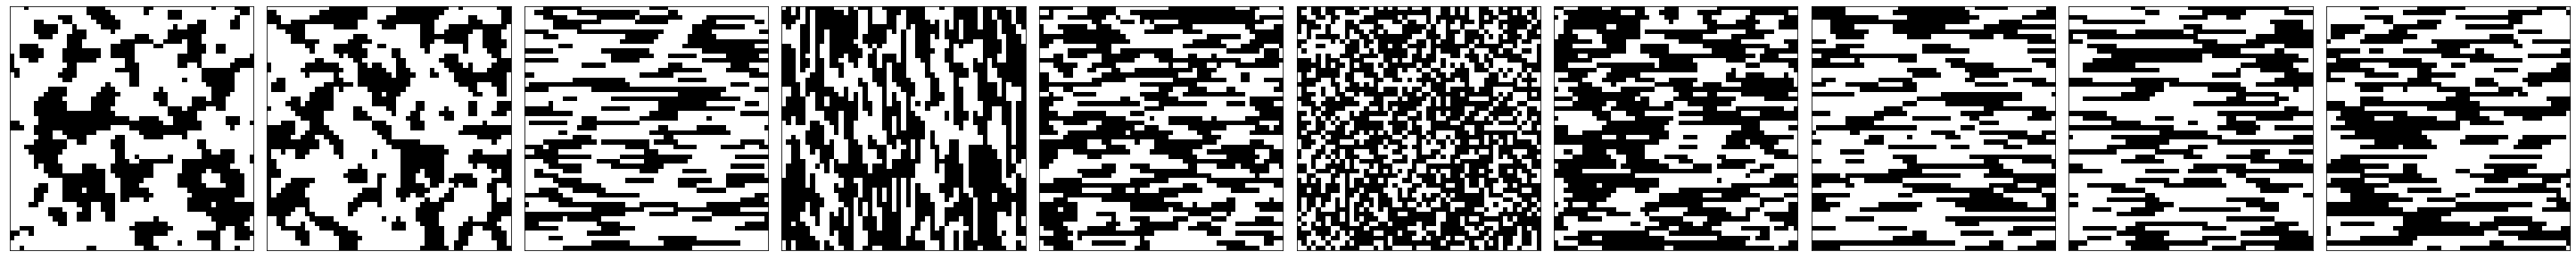

In [55]:
plot_microstructures(*x_data[:10], cmap='gray', colorbar=False);

In [56]:
import time
print(time.strftime('%l:%M%p %z on %b %d, %Y'))
y_data = oracle_from_data(x_data)
print(time.strftime('%l:%M%p %z on %b %d, %Y'))

11:11AM -0500 on Dec 13, 2022
11:28AM -0500 on Dec 13, 2022


2.5 minutes for 10 samples
28.2 minutes for 100 samples
20 hours for 1000 samples
about 5 hours for 1000 samples

In [58]:
np.savez_compressed('data51.npz', x_data=np.array(x_data), y_data=np.array(y_data))